# **A Novel Approach for Three-Way Classification of Lumbar Spine Degeneration Using Pseudo-Modality Learning to Handle Missing MRI Data**

## **Embeddings Architecture**

![MRI Processor Architecture](https://github.com/ahmedembeddedxx/lumbar-spine-degenerative-classification/blob/main/architecture/classifiers-architecture/mri-processor.png?raw=true)


## **Modules**

In [1]:
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import AutoModel
import torchvision.models as models

#### **Downloading Model**

In [2]:
import requests

url = "https://huggingface.co/TencentMedicalNet/MedicalNet-Resnet152/resolve/main/resnet_152.pth"

local_filename = "resnet_152.pth"

response = requests.get(url)

response.raise_for_status()

with open(local_filename, 'wb') as f:
    f.write(response.content)

print(f"Downloaded {local_filename}")

Downloaded resnet_152.pth


#### **Loading Model**

In [3]:
resnet152 = models.resnet152(pretrained=False)

weights_path = 'resnet_152.pth'
try:
    resnet152.load_state_dict(torch.load(weights_path), strict=False)
    print("ResNet-152 model loaded with custom weights (missing keys ignored).")
except RuntimeError as e:
    print(f"Failed to load weights: {e}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_23/2155055236.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

ResNet-152 model loaded with custom weights (missing keys ignored).


## **Attention Mechanism for MedicalNet152**

In [4]:
class MRIEmbeddingModel(torch.nn.Module):
    def __init__(self, base_model, embedding_dim):
        super(MRIEmbeddingModel, self).__init__()
        self.base_model = base_model
        self.attention_layer = torch.nn.Linear(embedding_dim, 1) 
        self.embedding_dim = embedding_dim

    def forward(self, x):
        attention_weights = self.attention_layer(x)
        final_embedding = torch.sum(x * attention_weights, dim=1)
        return final_embedding, attention_weights

In [5]:
def attention_embeddings(csv_path, img_path, result_path_csv, result_path_pth):
    model = resnet152
    model.fc = torch.nn.Linear(model.fc.in_features, 512)
    embedding_model = MRIEmbeddingModel(model, embedding_dim=512)

    model = model.to('cuda')
    embedding_model = embedding_model.to('cuda')

    df = pd.read_csv(csv_path)

    results = []
    for index, row in tqdm(df.iterrows()):
        patient_id = str(row['study_id'])
        series_id = str(row['series_id'])
    
        series_path = os.path.join(img_path, patient_id, series_id)

        embeddings = []

        for slice_file in os.listdir(series_path):
            if slice_file.endswith('.npy'):
                slice_path = os.path.join(series_path, slice_file)
                slice_data = np.load(slice_path)

                if slice_data.ndim == 2:
                    slice_data = np.stack([slice_data] * 3, axis=0)
                elif slice_data.ndim == 3 and slice_data.shape[0] == 1:
                    slice_data = np.repeat(slice_data, 3, axis=0)

                input_tensor = torch.from_numpy(slice_data).float().to('cuda')
                input_tensor = transforms.Resize((224, 224))(input_tensor)
                input_tensor = (input_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to('cuda')) / \
                               torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to('cuda')
                input_tensor = input_tensor.unsqueeze(0)

                with torch.no_grad():
                    embedding = model(input_tensor)
                    embeddings.append(embedding)

        if embeddings:
            slice_embeddings = torch.stack(embeddings, dim=1)
            slice_embeddings = slice_embeddings.to('cuda') 
            with torch.no_grad():
                final_embedding, attention_weights = embedding_model(slice_embeddings)

                final_embedding = final_embedding.squeeze().cpu()
                embedding_dict = {f'{i}': final_embedding[i].item() for i in range(final_embedding.shape[0])}

            embedding_dict.update({'study_id': patient_id, 'series_id': series_id})
            results.append(embedding_dict)

    results_df = pd.DataFrame(results)
    results_df.to_csv(result_path_csv, index=False)

    torch.save(embedding_model.state_dict(), result_path_pth)
    print(f"Embeddings with attention completed and saved to {result_path_csv}")

## **Running Inference**

In [6]:
attention_embeddings('/kaggle/input/preprocessed-dataset/train_data_AT2.csv', '/kaggle/input/preprocessed-dataset/grey_scale_train', 'AT2_attention_embeddings_gsl.csv', 'AT2_attention_model_gsl.pth')
attention_embeddings('/kaggle/input/preprocessed-dataset/train_data_AT2.csv', '/kaggle/input/preprocessed-dataset/hist_norm_train', 'AT2_attention_embeddings_hist.csv', 'AT2_attention_model_hist.pth')
attention_embeddings('/kaggle/input/preprocessed-dataset/train_data_ST2.csv', '/kaggle/input/preprocessed-dataset/grey_scale_train', 'ST2_attention_embeddings_gsl.csv', 'ST2_attention_model_gsl.pth')
attention_embeddings('/kaggle/input/preprocessed-dataset/train_data_ST2.csv', '/kaggle/input/preprocessed-dataset/hist_norm_train', 'ST2_attention_embeddings_hist.csv', 'ST2_attention_model_hist.pth')
attention_embeddings('/kaggle/input/preprocessed-dataset/train_data_ST1.csv', '/kaggle/input/preprocessed-dataset/grey_scale_train', 'ST1_attention_embeddings_gsl.csv', 'ST1_attention_model_gsl.pth')
attention_embeddings('/kaggle/input/preprocessed-dataset/train_data_ST1.csv', '/kaggle/input/preprocessed-dataset/hist_norm_train', 'ST1_attention_embeddings_hist.csv', 'ST1_attention_model_hist.pth')

2226it [43:50,  1.18s/it]


Embeddings with attention completed and saved to AT2_attention_embeddings_gsl.csv


2226it [43:54,  1.18s/it]


Embeddings with attention completed and saved to AT2_attention_embeddings_hist.csv


1876it [18:31,  1.69it/s]


Embeddings with attention completed and saved to ST2_attention_embeddings_gsl.csv


1876it [18:33,  1.68it/s]


Embeddings with attention completed and saved to ST2_attention_embeddings_hist.csv


1881it [19:11,  1.63it/s]


Embeddings with attention completed and saved to ST1_attention_embeddings_gsl.csv


1881it [18:52,  1.66it/s]


Embeddings with attention completed and saved to ST1_attention_embeddings_hist.csv


## **Plotting Embeddings**

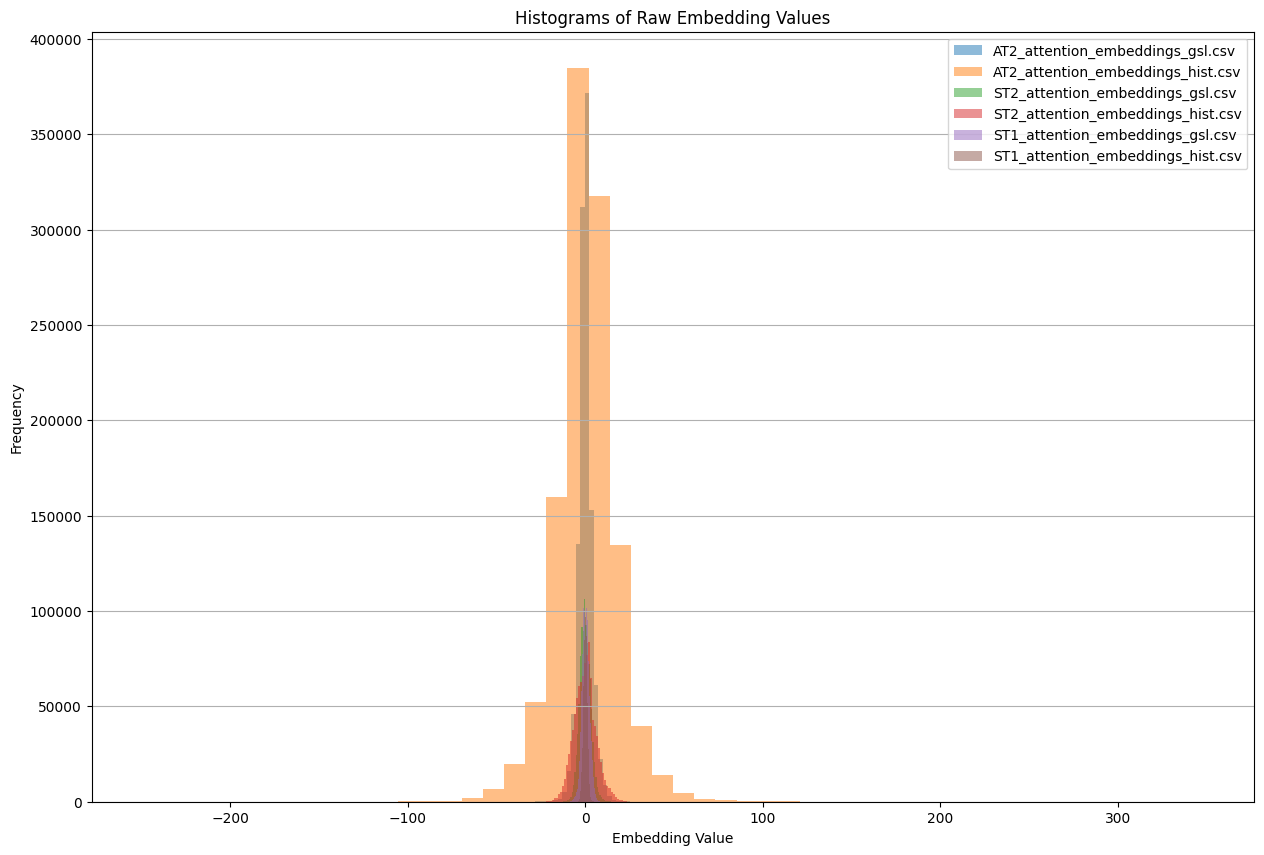

In [ ]:

file_paths = [
    '/kaggle/input/medicalnet-attention-layers-for-rsna/AT2_attention_embeddings_gsl.csv',
    '/kaggle/input/medicalnet-attention-layers-for-rsna/AT2_attention_embeddings_hist.csv',
    '/kaggle/input/medicalnet-attention-layers-for-rsna/ST2_attention_embeddings_gsl.csv',
    '/kaggle/input/medicalnet-attention-layers-for-rsna/ST2_attention_embeddings_hist.csv',
    '/kaggle/input/medicalnet-attention-layers-for-rsna/ST1_attention_embeddings_gsl.csv',
    '/kaggle/input/medicalnet-attention-layers-for-rsna/ST1_attention_embeddings_hist.csv',
]

plt.figure(figsize=(15, 10))
for file_path in file_paths:
    df = pd.read_csv(file_path)

    embeddings = df.iloc[:, :512]

    flattened_embeddings = embeddings.values.flatten()

    legend_label = file_path.split('/')[-1]
    
    plt.hist(flattened_embeddings, bins=50, alpha=0.5, label=legend_label)

plt.title('Histograms of Raw Embedding Values')
plt.xlabel('Embedding Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()
